# Compare tfidf vectors

As a baseline measurement of textual distance, we should try good old cosine distance on tfidf vectors.

In [1]:
import csv
import pandas as pd
import numpy as np
import math, sys
from collections import Counter
from scipy import spatial
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
%matplotlib inline

### Most common 10,000 words by document frequency

I'm restricting this mostly to real English words, plus a few ringers.

In [2]:
realwords = set()

with open('/Users/tunder/Dropbox/DataMunging/rulesets/MainDictionary.txt', encoding = 'utf-8') as f:
    for line in f:
        fields = line.strip().split('\t')
        realwords.add(fields[0])

special_allowed = {'#arabicnumeral', '#personalname', '#placename', 
                   '#monthoftheyear', '#romannumeral', '#dayoftheweek',
                  'bullshit', "n't", "'ll", "'ve", "'d", "'re", "'em",
                  'ing', 'a.m.', 'p.m.'}

In [3]:
docfreq = Counter()

with open('../parsejsons/rawcounts.tsv', encoding = 'utf-8') as f:
    docset = set()
    wordset = set()
    
    for line in f:
        row = line.strip().split('\t')
        doc = row[0]
        if doc == 'docid':
            continue
        if doc not in docset:
            docset.add(doc)
            wordset = set()
            
        word = row[1]
        if word not in realwords and len(word) > 1 and word not in special_allowed:
            stripped_word = word.strip(".,—'-\"")
            if stripped_word not in realwords:
                continue
            else:
                word = stripped_word
                
        if word not in wordset:        
            docfreq[word] += 1
            wordset.add(word)

common = docfreq.most_common(10000)

In [4]:
len(docset)

6846

### Turn the list of common words into two handy variables

1. A **lexindex** that maps words to positions in a vector.

2. An **inverse document frequency vector** that has idf for each word.

In [5]:
lexindex = dict()
idfvec = np.zeros(10000)

for idx, atuple in enumerate(common):
    word, count = atuple
    lexindex[word] = idx
    idf = math.log(6847 /count)
    idfvec[idx] = idf

### Create document vectors

In [6]:
docvec = dict()

with open('../parsejsons/rawcounts.tsv', encoding = 'utf-8') as f:
    docset = set()
    wordset = set()
    
    for line in f:
        row = line.strip().split('\t')
        doc = row[0]
        if doc == 'docid':
            continue
        if doc not in docvec:
            docvec[doc] = np.zeros(10000)
            
        word = row[1]
        if word not in lexindex:
            stripped_word = word.strip(".,—'-\"")
            if stripped_word not in lexindex:
                continue
            else:
                word = stripped_word
        
        idx = lexindex[word]
        count = int(row[2])
        docvec[doc][idx] = docvec[doc][idx] + count

### Now, to create genre vectors

In [7]:
# Metadata by volume

meta = pd.read_csv('../metadata/genremeta.csv')

In [8]:
# Lists of genre types

genrenamedf = pd.read_csv('../metadata/selected_genres.tsv', sep = '\t')
primaries = genrenamedf.loc[genrenamedf.genretype == 'primary', 'genre'].tolist()
bgenres = genrenamedf.loc[genrenamedf.genretype == 'B genre', 'genre'].tolist()
intersection_genres = set(genrenamedf.loc[genrenamedf.genretype == 'intersection', 'genre'].tolist())

We're going to create a tdf-idf vector in a dictionary for all the primary genres, and also the b genres, which will be used when we need a self-comparison for a primary genre.

In [9]:
def has_genre(row, genre):
    g = row.tags
    tags = g.split('|')
    if genre in tags:
        return row.docid
    else:
        return None
    
def sum_genre(meta, genre, docvec):
    global missing
    
    genredocs = meta.apply(has_genre, args = ([genre]), axis = 1)
    genredocs = set(genredocs)
    genredocs.remove(None)
    vector = np.zeros(10000)
    for g in genredocs:
        if g in docvec:
            vector = vector + docvec[g]
        else:
            print('missing volume: ' + g)
            missing.add(g)
    return vector
    
def tfidf(genre, meta, docvec, idfvec):
    vector = sum_genre(meta, genre, docvec)
    genre_tfidf = vector * idfvec
    return genre_tfidf
        
tfidf_dict = dict()
for g in primaries:
    tfidf_dict[g] = tfidf(g, meta, docvec, idfvec)
for g in bgenres:
    tfidf_dict[g] = tfidf(g, meta, docvec, idfvec)
    

### Calculate cosine distances

in a dictionary indexed by genre. The two levels of indexing correspond to horizontal and vertical columns in a square matrix.

In [10]:
cosdist = dict()

for g1 in primaries:
    cosdist[g1] = dict()
    
    for g2 in primaries:
        if g1 == g2:
            bversion = g1 + ' B'
            if bversion in bgenres:
                cos = spatial.distance.cosine(tfidf_dict[g1], tfidf_dict[bversion])
                cosdist[g1][g2] = cos
            else:
                cosdist[g1][g2] = float('nan')
        else:                  
            cos = spatial.distance.cosine(tfidf_dict[g1], tfidf_dict[g2])
            cosdist[g1][g2] = cos

To actually see this as a square matrix, turn it into a DataFrame. Note that the matrix has NaNs for self-comparisons in cases where we didn't have a b genre (not enough volumes to create two 100-vol non-overlapping sets).

In [11]:
tfidf_matrix = pd.DataFrame(cosdist)
tfidf_matrix

,Adventure,Bildungsroman,Biographical,Christian,Domestic,Fantasy,Historical,Horror,Humor,Juvenile,...,Subj: Man-woman,"Subj: SF, American","Subj: SF, Other","Subj: Short stories, American","Subj: Short stories, Other",Suspense,War,Western,randomA,randomB
Adventure,NaN,0.215407,0.199642,0.260315,0.206762,0.190834,0.170432,0.138238,0.148604,0.383599,...,0.178040,0.179561,0.195415,0.140442,0.206556,0.131357,0.259138,0.286827,0.157743,0.183033
Bildungsroman,0.215407,0.089377,0.220538,0.249258,0.110317,0.282145,0.214894,0.177725,0.136659,0.446072,...,0.156224,0.295543,0.318660,0.123178,0.171977,0.224476,0.418199,0.344066,0.171012,0.192143
Biographical,0.199642,0.220538,NaN,0.235840,0.271428,0.166897,0.086026,0.212162,0.257784,0.286974,...,0.258573,0.264828,0.279655,0.161008,0.154723,0.304751,0.303013,0.282813,0.110672,0.115191
Christian,0.260315,0.249258,0.235840,NaN,0.251978,0.261507,0.233775,0.238864,0.237130,0.392186,...,0.271255,0.332096,0.361432,0.214096,0.245570,0.300244,0.432282,0.365125,0.193524,0.205745
Domestic,0.206762,0.110317,0.271428,0.251978,0.084298,0.288101,0.262948,0.161942,0.101594,0.525189,...,0.140274,0.307714,0.332480,0.144962,0.211762,0.174815,0.435733,0.347882,0.215681,0.244356
Fantasy,0.190834,0.282145,0.166897,0.261507,0.288101,0.075878,0.166715,0.160621,0.266341,0.372549,...,0.274202,0.194721,0.217688,0.211394,0.219305,0.290024,0.368976,0.315600,0.182388,0.193351
Historical,0.170432,0.214894,0.086026,0.233775,0.262948,0.166715,0.074209,0.214501,0.251976,0.284538,...,0.250360,0.255777,0.262616,0.147533,0.148778,0.284331,0.242461,0.243348,0.107808,0.113895
Horror,0.138238,0.177725,0.212162,0.238864,0.161942,0.160621,0.214501,NaN,0.135867,0.436137,...,0.141328,0.175421,0.206543,0.137677,0.185562,0.135647,0.398620,0.329338,0.146094,0.168538
Humor,0.148604,0.136659,0.257784,0.237130,0.101594,0.266341,0.251976,0.135867,0.082859,0.498758,...,0.108212,0.255189,0.283072,0.126975,0.210305,0.124572,0.410969,0.342045,0.191324,0.215765
Juvenile,0.383599,0.446072,0.286974,0.392186,0.525189,0.372549,0.284538,0.436137,0.498758,0.151389,...,0.496153,0.448836,0.431378,0.311044,0.307173,0.555478,0.381488,0.442721,0.219478,0.208279


### Compare cosine distance to evidence about social distance

we'll skip the NaNs and also ignore ```randomA``` and ```randomB.```

In [12]:
social = pd.read_csv('../socialmeasures/pmidf.csv', index_col = 'index')

In [13]:
def compare_to_social(socialdf, otherdf, use_self = False):
    ''' Compares two DataFrames, ignoring cells as instructed,
    and exporting the results in two vectors for correlation.
    '''

    socialvals = []
    othervals = []

    for idx1 in socialdf.index:
        for idx2 in socialdf.index:
            if idx1 not in otherdf.index or idx2 not in otherdf.index:
                continue
                
            otherval = otherdf.loc[idx1, idx2]
            if pd.isnull(otherval):
                continue
            elif not use_self and idx1 == idx2:
                continue
            else:
                sval = socialdf.loc[idx1, idx2]
                socialvals.append(sval)
                othervals.append(otherval)
                
    return socialvals, othervals

socialvals, tfidfvals = compare_to_social(social, tfidf_matrix, use_self = False)
pearsonr(socialvals, tfidfvals)

(-0.25169966546162714, 8.4535573066792535e-16)

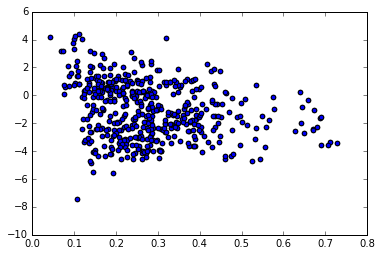

In [14]:
plt.scatter(tfidfvals, socialvals)
plt.show()

### Interpretation

The correlation is significantly worse than for topic vectors, and certainly not competitive with predictive models.

One underlying problem (for both tfidf and topics) seems to be that raw distances interpret many genres as being relatively close, and only a few as being remote from each other. But predictive distances, and social distances, are going to be structured differently: many genres are relatively remote, and only a few have significant proximity.

#### bootstrap resampling for uncertainty 

In [15]:
import random

def bootstrap(vec1, vec2):
    assert len(vec1) == len(vec2)
    n = len(vec1)
    indices = []
    for i in range(n):
        indices.append(random.randrange(n))
    bs1 = [vec1[x] for x in indices]
    bs2 = [vec2[x] for x in indices]
    return bs1, bs2

def boot_sample(vec1, vec2):
    corrs = []
    for i in range(10000):
        bs1, bs2 = bootstrap(vec1, vec2)
        r = pearsonr(bs1, bs2)
        corrs.append(r[0])
    corrs.sort()
    return corrs

uncertainty = boot_sample(tfidfvals, socialvals)
print(uncertainty[500], uncertainty[9500])

-0.298753424217 -0.204835758627


In [16]:
with open('../results/bootstrapped_tfidf_r.txt', mode = 'w', encoding = 'utf-8') as f:
    for u in uncertainty:
        f.write(str(u) + '\n')